# Diffusion Part 2
Now that we have walked through the diffusion process, we can abstract everything away into some classes and folders. We have stored our U-Net in a python file `unet.py`, the data loading into a `utils.py` files, and finally, the main diffusion algorthim in the `ddpm.py` file. From here on, we call the `DDPM` class the `scheduler`...because that's essentially what it does.

So now we can simply import all these classes and run the diffusion process in a few lines of code.

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import sys
import numpy as np

## Get the data

In [2]:
sys.path.append('..') # Add parent directory to path so we can grab the code that we need in the diffusion_models directory
from diffusion_models.utils import *
from diffusion_models.unet import UNetSmol
from diffusion_models.ddpm import DDPM

DATA_PATH = '../data/'
train_loader, test_loader = get_mnist(32, DATA_PATH)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Get the model and optimizer

In [59]:
unet = UNetSmol(input_channels=1,
                output_channels=1,
                block_channels=[32,64,128])
optimizer = optim.AdamW(unet.parameters(), lr=0.001)

### Define the scheduler
We will increase the steps to 500. In many bigger and better models, the steps could be in the thousands.

In [61]:
scheduler = DDPM(
    model = unet,
    optimizer = optimizer,
    T = 500,
    start = 0.0001,
    end = 0.02,
)

## Train for a few epochs
Here, "a few" epochs is actually 20. This will probably take over an hour to run on something like a Macbook Pro, so you might want to reduce this down (or increase it if you want to push the model!)

In [62]:
losses, t_values = scheduler.train(train_loader, epochs=20)

Training: 100%|██████████| 1875/1875 [03:35<00:00,  8.71it/s]


Epoch [1/20], Loss: 0.0757


Training: 100%|██████████| 1875/1875 [03:35<00:00,  8.71it/s]


Epoch [2/20], Loss: 0.0541


Training: 100%|██████████| 1875/1875 [03:31<00:00,  8.88it/s]


Epoch [3/20], Loss: 0.0502


Training: 100%|██████████| 1875/1875 [03:27<00:00,  9.03it/s]


Epoch [4/20], Loss: 0.0478


Training: 100%|██████████| 1875/1875 [03:28<00:00,  8.99it/s]


Epoch [5/20], Loss: 0.0458


Training: 100%|██████████| 1875/1875 [03:28<00:00,  9.00it/s]


Epoch [6/20], Loss: 0.0444


Training: 100%|██████████| 1875/1875 [03:28<00:00,  8.98it/s]


Epoch [7/20], Loss: 0.0445


Training: 100%|██████████| 1875/1875 [03:27<00:00,  9.04it/s]


Epoch [8/20], Loss: 0.0433


Training: 100%|██████████| 1875/1875 [03:36<00:00,  8.68it/s]


Epoch [9/20], Loss: 0.0427


Training: 100%|██████████| 1875/1875 [03:30<00:00,  8.89it/s]


Epoch [10/20], Loss: 0.0425


Training: 100%|██████████| 1875/1875 [03:27<00:00,  9.05it/s]


Epoch [11/20], Loss: 0.0424


Training: 100%|██████████| 1875/1875 [03:37<00:00,  8.61it/s]


Epoch [12/20], Loss: 0.0420


Training: 100%|██████████| 1875/1875 [03:30<00:00,  8.92it/s]


Epoch [13/20], Loss: 0.0418


Training: 100%|██████████| 1875/1875 [03:31<00:00,  8.88it/s]


Epoch [14/20], Loss: 0.0414


Training: 100%|██████████| 1875/1875 [03:27<00:00,  9.06it/s]


Epoch [15/20], Loss: 0.0411


Training: 100%|██████████| 1875/1875 [03:32<00:00,  8.83it/s]


Epoch [16/20], Loss: 0.0411


Training: 100%|██████████| 1875/1875 [03:31<00:00,  8.87it/s]


Epoch [17/20], Loss: 0.0409


Training: 100%|██████████| 1875/1875 [03:39<00:00,  8.55it/s]


Epoch [18/20], Loss: 0.0406


Training: 100%|██████████| 1875/1875 [03:32<00:00,  8.84it/s]


Epoch [19/20], Loss: 0.0406


Training: 100%|██████████| 1875/1875 [03:30<00:00,  8.91it/s]

Epoch [20/20], Loss: 0.0404


## Loss curves
It is well know that loss curves in diffusion models seem to suddenly decrease and then become very noisy and "converge". This behaviour is expected in diffusion models. Predicting noise is actually fairly easy when t is very high, and the model therefore becomes very good early on in the training. However, the model also needs to be able to predict low noise (i.e. when t is small), which it remains bad at.

When you just look at the loss for all values of t mixed up, you can't see the progress. However if you look at each loss curves for only a single value of t, you will see improvement.

Let's test this theory but first plotting the overall loss for each batch, and then the loss function for each time step.

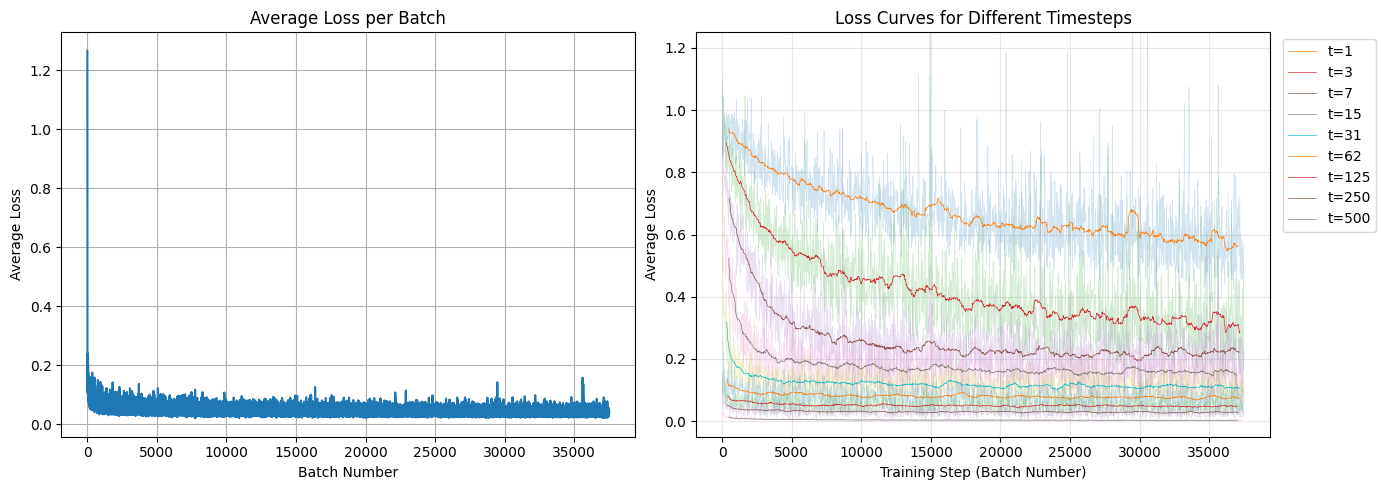

In [110]:
batch_size = 32
n_batches = len(losses) // batch_size

# Calculate which training step (batch number) each sample came from
training_steps = np.repeat(range(n_batches), batch_size)[:len(losses)]
batch_losses = np.array(losses[:n_batches * batch_size]).reshape(-1, batch_size).mean(axis=1)
batch_t = np.array(t_values[:n_batches * batch_size]).reshape(-1, batch_size).mean(axis=1)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharex=True)

ax1.plot(range(len(batch_losses)), batch_losses)
ax1.set_xlabel('Step')
ax1.set_ylabel('Average Loss')
ax1.set_title('Average Loss per Batch')
ax1.grid()

# Select a few timesteps to plot
unique_t = np.unique(t_values)
n_curves = 10
# Use exponential spacing to get more samples at lower timesteps
indices = np.geomspace(1, len(unique_t), n_curves).astype(int) - 1
selected_t = unique_t[indices]

for t in selected_t[1:]:
    # Get losses and corresponding training steps for this timestep
    mask = np.array(t_values) == t
    t_losses = np.array(losses)[mask]
    t_steps = training_steps[mask]
    
    # Sort by training steps to ensure correct plotting order
    sort_idx = np.argsort(t_steps)
    t_losses = t_losses[sort_idx]
    t_steps = t_steps[sort_idx]

    window = 51  # Must be odd number
    smoothed_losses = np.convolve(t_losses, np.ones(window)/window, mode='valid')
    valid_steps = t_steps[window//2:-(window//2)]

    ax2.plot(t_steps, t_losses, alpha=0.2, lw=0.5)
    ax2.plot(valid_steps, smoothed_losses, label=f't={int(t)+1}', alpha=1., lw=0.5)
    
    
ax2.set_xlabel('Step')
ax2.set_ylabel('Average Loss')
ax2.set_title('Loss Curves for Different Timesteps')
ax2.set_ylim(-0.05, 1.25)
ax2.grid(True, alpha=0.3)
ax2.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

plt.tight_layout()
fig.subplots_adjust(right=0.85)
plt.show()

Sure enough, the average loss per batch appears to have plateaued. When we look at the loss from individual timesteps however, we can see that the curves corresponding to low values of t are still decreasing. Had we stopped training based on the left plot, we would be depriving our model of learning those fine details and relationships.

## Sampling
Let's sample a number from the model, for example the number 6.

In [94]:
x_ts = scheduler.sample(6, 10)
x_ts = np.array(x_ts)

100%|██████████| 500/500 [00:05<00:00, 85.25it/s]


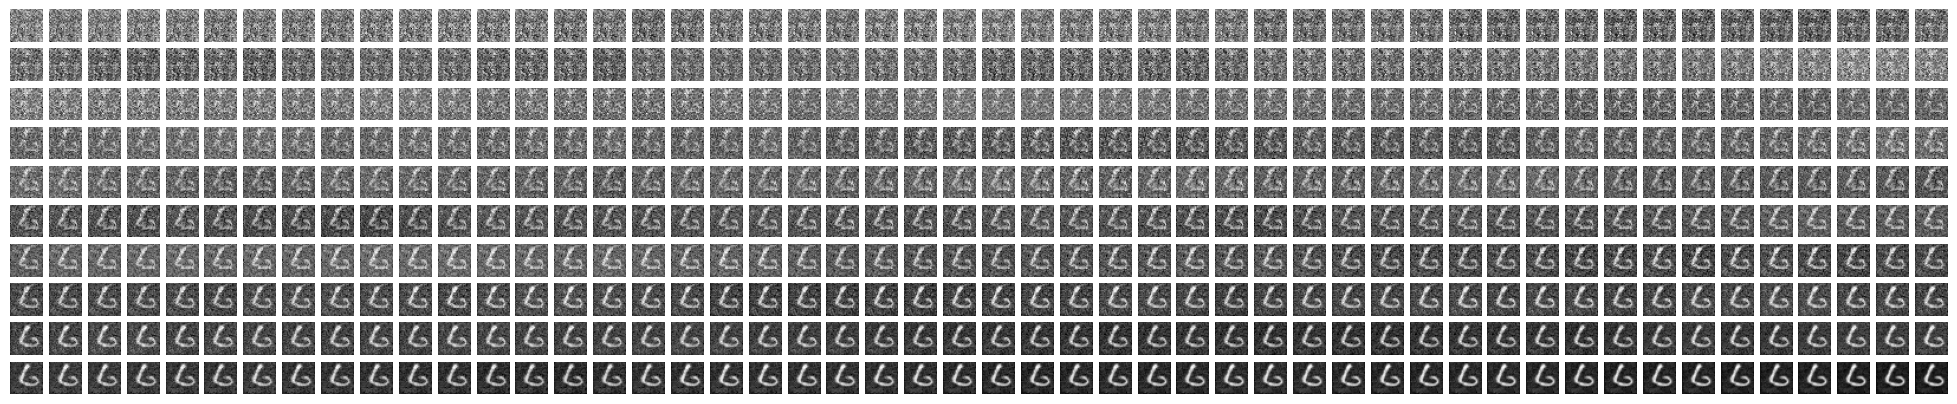

In [95]:
plt.figure(figsize=(25,5))

single = x_ts[:, 0, :, :]

for t in range(scheduler.T):
    img = single[t].squeeze()
    ax = plt.subplot(10, 50, t + 1)
    ax.axis("off")
    plt.imshow(img, cmap="gray")

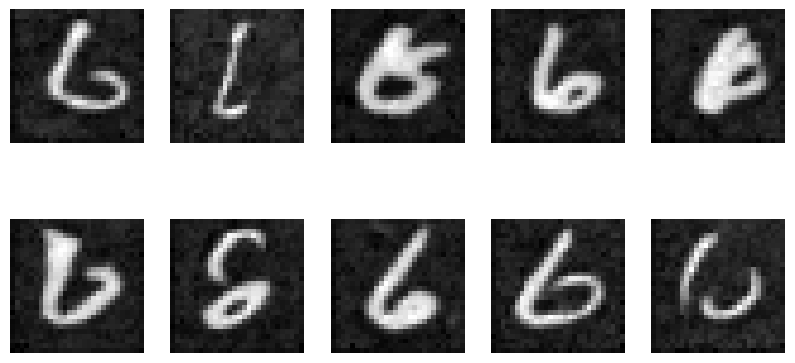

In [97]:
example = x_ts[-1]

plt.figure(figsize=(10, 5))
for i in range(10):
    img = example[i][0]
    ax = plt.subplot(2, 5, i + 1)
    ax.axis('off')
    plt.imshow(img, cmap='gray')

These results are really not bad considering that we only trained a very small model on a few epochs! Feel free to adjust the hyperparameters however you want. You'll notice that as you increase the number of epochs and the size of the model, you'll get significantly better results.

## Next steps
We built a lot of this from scratch. Surely someone has done this process for us already? Yes, they have! The `diffusers` library is a PyTorch library that implements the diffusion process and provides a lot of utilities to make the process easier.